In [31]:
# required libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression, LinearRegression, BayesianRidge, \
    Lasso, SGDClassifier, TweedieRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import commonteamroster, playergamelog, teamgamelog
from nba_api.live.nba.endpoints import scoreboard, boxscore
from IPython.display import display, HTML

In [32]:
# endpoints: https://github.com/swar/nba_api/tree/master/docs/nba_api/stats/endpoints

header_dict = {
    'User-Agent': 'Mozilla/5.0',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true',
    'Referer': 'https://stats.nba.com',
    'Connection': 'keep-alive',
    'Pragma': 'no-cache',
    'Cache-Control': 'no-cache',
    'Host': 'stats.nba.com'
}


teams_dict = {'ATL': 0, 'BOS': 1, 'CHA': 2, 'CHI': 3, 'CLE': 4, 'DAL': 5, 'DEN': 6, 'DET': 7, 'GSW': 8, 'HOU': 9, 'IND': 10,
         'LAC': 11, 'LAL': 12, 'MEM': 13, 'MIA': 14, 'MIL': 15, 'MIN': 16, 'NOP': 17, 'NYK': 18, 'BKN': 19, 'OKC': 20,
         'ORL': 21, 'PHI': 22, 'PHX': 23, 'POR': 24, 'SAC': 25, 'SAS': 26, 'TOR': 27, 'UTA': 28, 'WAS': 29}


def get_playerID(name):
    all_players = players.get_players()

    for ind in range(len(all_players)):
        if all_players[ind]['full_name'].upper() == name.upper():
            return all_players[ind]['id']
    return ''

def get_teamID(team):
    all_teams = teams.get_teams()
    
    for item in all_teams:
        if item['abbreviation'] == team:
            return item['id']
    return ''

In [33]:
# PLAYER'S NAME
player_name = "Jaren Jackson Jr."

# BETTING STAT
betting_stat = "PR"

# PROJECTED BETTING STAT
projected_betting_stat = 23.5

In [34]:
player_id = get_playerID(player_name)
url = f"https://stats.nba.com/stats/playergamelog?PlayerID={player_id}&Season=2022-23" \
      f"&SeasonType=Regular+Season"
# print(url)

response = requests.request("GET", url, headers=header_dict)
json = response.json()

stats_names = json['resultSets'][0]['headers']
game_stats = json['resultSets'][0]['rowSet']

df = pd.DataFrame(game_stats, columns=stats_names)
df = df.drop(['SEASON_ID', 'Player_ID', 'VIDEO_AVAILABLE', "Game_ID", "GAME_DATE"], axis=1)
df.loc[df['WL'] == 'L', 'WL'] = 0  # 0 for loss
df.loc[df['WL'] == 'W', 'WL'] = 1  # 1 for win

if betting_stat == "FANTASY":
    stats_sum = df['PTS'] + (1.2*df['REB']) + (1.5*df['AST']) + (3*df['BLK']) + (3*df['STL']) - df['TOV']
    df['FANTASY'] = stats_sum.astype(int)

if betting_stat == 'PRA':
    stats_sum = df['PTS'] + df['REB'] + df['AST']
    df['PRA'] = stats_sum

if betting_stat == 'PR':
    stats_sum = df['PTS'] + df['REB']
    df['PR'] = stats_sum

if betting_stat == 'PA':
    stats_sum = df['PTS'] + df['AST']
    df['PA'] = stats_sum

if betting_stat == 'RA':
    stats_sum = df['REB'] + df['AST']
    df['RA'] = stats_sum

if betting_stat == 'BLK+STL':
    stats_sum = df['BLK'] + df['STL']
    df['BLK+STL'] = stats_sum

df['OVER_UNDER'] = df[betting_stat].gt(projected_betting_stat).astype(int)

# mark team matchup as number
updated_matchup_column = []
for matchup in df['MATCHUP']:
    team = matchup[-3:]
    updated_matchup_column.append(teams_dict[team])
df['MATCHUP'] = updated_matchup_column

print(f"2022-2023 Season stats for {player_name}")
# display(HTML(df.to_html()))

2022-2023 Season stats for Jaren Jackson Jr.


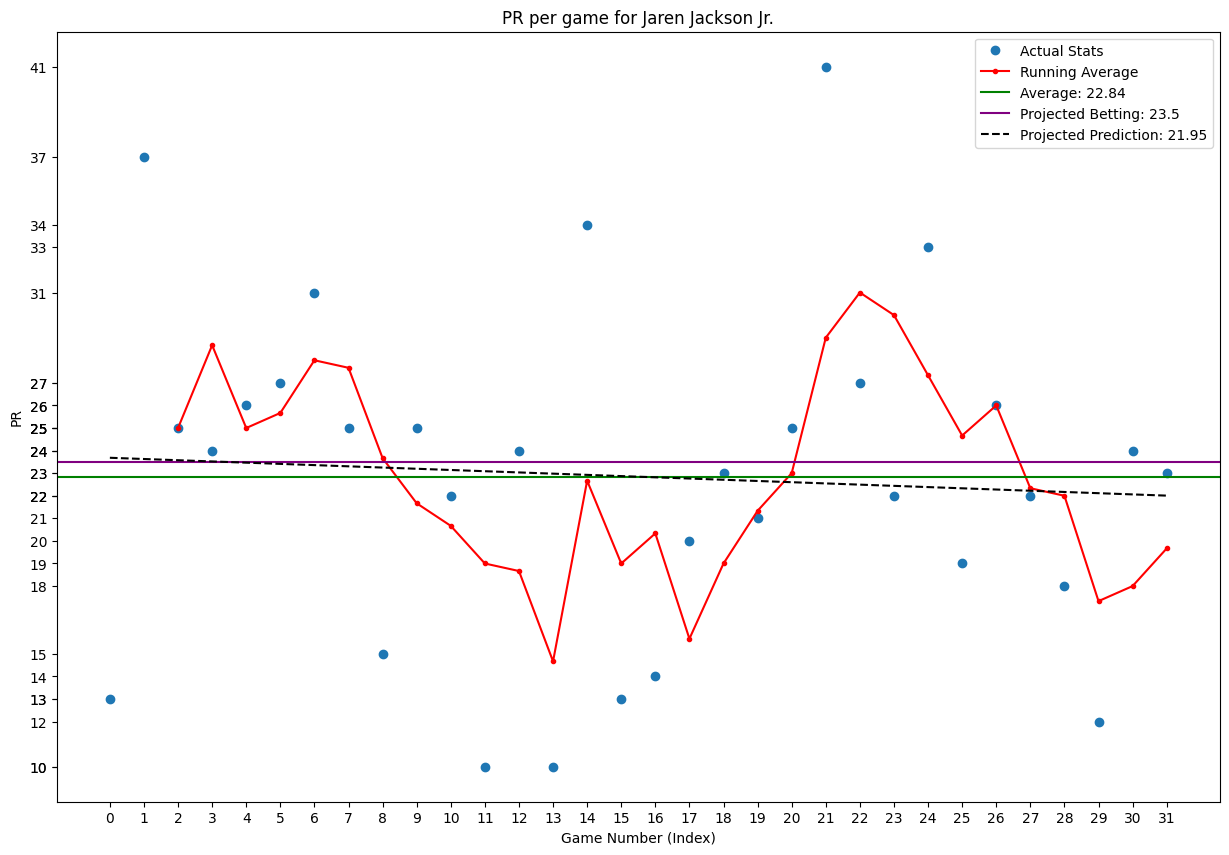

In [35]:
stats_values = df[betting_stat].values[::-1]
x = np.arange(0, len(stats_values))
y = np.arange(0, max(stats_values)+1)
mean = np.average(stats_values)

window = 3
average_y = []
y = stats_values

for ind in range(len(y) - window + 1):
    average_y.append(np.mean(y[ind:ind+window]))

for ind in range(window - 1):
    average_y.insert(0, np.nan)


plt.rcParams["figure.figsize"] = [15, 10]
plt.xlabel('Game Number (Index)')
plt.ylabel(betting_stat)
plt.title(f"{betting_stat} per game for {player_name}")
plt.xticks(x)
plt.yticks(y)

coef = np.polyfit(x, stats_values, 1)
poly1d_fn = np.poly1d(coef)
poly1d_prediction = poly1d_fn(max(x)+1)

plt.plot(x, stats_values, 'o', label="Actual Stats")
plt.plot(x, average_y, 'r.-', label='Running Average')
plt.axhline(y=mean, color="green", label=f"Average: {round(mean, 2)}")
plt.axhline(y=projected_betting_stat, color="purple", label=f"Projected Betting: {projected_betting_stat}")
plt.plot(poly1d_fn(x), '--k', label=f"Projected Prediction: {round(poly1d_prediction, 2)}")
plt.legend()
plt.show()

In [36]:
print(f"Projecting predictions on over/under {projected_betting_stat} {betting_stat} for {player_name}...")
print(f"{betting_stat} average: {mean}")
print(f"{betting_stat} poly_1d prediction: {poly1d_prediction}")
# print(f"\n{betting_stat} per game for {player_name}: {stats_values}")


# Begin Predictive Modeling (work on hyperparameter tuning)
X = []
for i in range(0, len(df)):
    X.append([i, stats_values[i]])

Y = stats_values
threshold = 0.5
labels = [projected_betting_stat-threshold, projected_betting_stat+threshold]


# Bayesian Ridge Regression
model = BayesianRidge()
model.fit(X, Y)
prediction = model.predict([labels])
score = model.score(X, Y)
print(f"\nBayesian Ridge Regression prediction: {prediction}")
print(f"Omega coefficient for predicting under {projected_betting_stat} {betting_stat}: {model.coef_[0]:.20f}")
print(f"Omega coefficient for predicting over {projected_betting_stat} {betting_stat}: {model.coef_[1]:.20f}")
print(f"Accuracy score: {score}")


# Linear Regression
model = LinearRegression()
model.fit(X, Y)
prediction = model.predict([labels])
score = model.score(X, Y)
print(f"\nLinear Regression predictions: {prediction}")
print(f"Omega coefficient for predicting under {projected_betting_stat} {betting_stat}: {model.coef_[0]:.20f}")
print(f"Omega coefficient for predicting over {projected_betting_stat} {betting_stat}: {model.coef_[1]:.20f}")
print(f"Accuracy score: {score}")


# Generalized Linear Model (Tweedie Regressor)
model = TweedieRegressor(power=1, alpha=0.5, link='log')
model.fit(X, Y)
prediction = model.predict([labels])
score = model.score(X, Y)
print(f"\nGLM (Tweedie Regressor) Classifier predictions: {prediction}")
print(f"Omega coefficient for predicting under {projected_betting_stat} {betting_stat}: {model.coef_[0]:.20f}")
print(f"Omega coefficient for predicting over {projected_betting_stat} {betting_stat}: {model.coef_[1]:.20f}")
print(f"Accuracy score: {score}")


# Lasso
model = Lasso(alpha=0.1)
model.fit(X, Y)
prediction = model.predict([labels])
score = model.score(X, Y)
print(f"\nLasso predictions: {prediction}")
print(f"Accuracy score: {score}")


# Logistic Regression
model = LogisticRegression(penalty="l2", solver="liblinear")
model.fit(X, Y)
prediction = model.predict([labels])
score = model.score(X, Y)
print(f"\nLogistic Regression predictions: {prediction}")
print(f"Logistic Regression Classes: {model.classes_}")
print(f"Accuracy score: {score}")


# Stochastic Gradient Descent
model = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
model.fit(X, Y)
prediction = model.predict([labels])
score = model.score(X, Y)
print(f"\nSGD Classifier predictions: {prediction}")
print(f"Accuracy score: {score}")


# K Nearest Neighbors
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X, Y)
prediction = model.predict([labels])
score = model.score(X, Y)
print(f"\nkNN predictions: {prediction}")
print(f"kNN Classes: {model.classes_}")
print(f"Accuracy score: {score}")

Projecting predictions on over/under 23.5 PR for Jaren Jackson Jr....
PR average: 22.84375
PR poly_1d prediction: 21.951612903225808

Bayesian Ridge Regression prediction: [24.]
Omega coefficient for predicting under 23.5 PR: -0.00000000000417630624
Omega coefficient for predicting over 23.5 PR: 0.99999999992276045191
Accuracy score: 1.0

Linear Regression predictions: [24.]
Omega coefficient for predicting under 23.5 PR: -0.00000000000000004192
Omega coefficient for predicting over 23.5 PR: 1.00000000000000000000
Accuracy score: 1.0

GLM (Tweedie Regressor) Classifier predictions: [22.9135813]
Omega coefficient for predicting under 23.5 PR: 0.00048592491614651709
Omega coefficient for predicting over 23.5 PR: 0.04218791112487416811
Accuracy score: 0.9530219827304445

Lasso predictions: [23.99786647]
Accuracy score: 0.999996595195331

Logistic Regression predictions: [22]
Logistic Regression Classes: [10 12 13 14 15 18 19 20 21 22 23 24 25 26 27 31 33 34 37 41]
Accuracy score: 0.21875
